In [1]:
import os
import sys
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_cosine_schedule_with_warmup
from tqdm import tqdm
from scipy.special import softmax
import joblib
import zipfile
import transformers
import sklearn
transformers.logging.set_verbosity_error()

In [2]:
# Logging setup
logger = logging.getLogger()
logger.setLevel(logging.INFO)
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter('%(message)s'))
logger.addHandler(handler)

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device count: {torch.cuda.device_count()}")

Using device: cuda
CUDA device name: Tesla T4
CUDA device count: 1


In [4]:
# Log library versions
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.6.0+cu124
Transformers version: 4.52.4
Scikit-learn version: 1.6.1
Pandas version: 2.2.2
NumPy version: 2.0.2


In [17]:
# Configuration
MODEL_NAME = 'roberta-base'
TEXT_COLUMN = 'processed_text'
LABEL_COLUMN = 'status'
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100
DROPOUT_RATE = 0.1

In [18]:
# Custom Label Smoothing Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, class_weights=None):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.class_weights = class_weights

    def forward(self, input, target):
        logprobs = F.log_softmax(input, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        if self.class_weights is not None:
            weights = self.class_weights[target]
            loss = loss * weights
        return loss.mean()

In [19]:
# Data preparation functions
def prepare_model_input(texts, labels, tokenizer, max_length):
    # Tokenize texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    # Handle labels
    if isinstance(labels, pd.Series):
        labels = labels.values

    # Convert string labels to numeric if necessary
    if labels.dtype == 'object' or isinstance(labels[0], str):
        le = LabelEncoder()
        labels = le.fit_transform(labels)

    # Convert to tensor
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return input_ids, attention_mask, labels_tensor

def create_dataloader(input_ids, attention_mask, labels, batch_size, shuffle=True):
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [20]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs, device, patience=2, dropout_rate=DROPOUT_RATE, warmup_steps=WARMUP_STEPS):
    torch.cuda.empty_cache()
    try:
        # Log training configuration
        logger.info("Training Configuration:")
        logger.info(f"  Model: {MODEL_NAME}")
        logger.info(f"  Max Length: {MAX_LENGTH}")
        logger.info(f"  Batch Size: {BATCH_SIZE}")
        logger.info(f"  Epochs: {EPOCHS}")
        logger.info(f"  Learning Rate: {LEARNING_RATE}")
        logger.info(f"  Dropout Rate: {dropout_rate}")
        logger.info(f"  Warmup Steps: {warmup_steps}")
        logger.info(f"  Train Samples: {len(train_loader.dataset)}")
        logger.info(f"  Validation Samples: {len(val_loader.dataset)}")

        # Count model parameters
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        logger.info(f"  Total Trainable Parameters: {total_params:,}")

        status_weights = torch.tensor(compute_class_weight(
            'balanced', classes=np.unique(train_loader.dataset.tensors[2].numpy()),
            y=train_loader.dataset.tensors[2].numpy()
        ), dtype=torch.float).to(device)

        scaler = torch.amp.GradScaler('cuda')
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1, class_weights=status_weights)
        best_val_f1 = 0.0
        epochs_no_improve = 0
        model_save_path = "best_roberta_model_f1.pt"

        # Store metrics
        metrics = {
            'train_loss': [],
            'train_acc': [],
            'train_f1': [],
            'val_loss': [],
            'val_acc': [],
            'val_f1': [],
            'best_epoch': 0,
            'best_val_f1': 0.0
        }

        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            train_preds, train_labels = [], []
            total_train_samples = 0

            train_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", total=len(train_loader))
            for batch_idx, batch in enumerate(train_tqdm):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                batch_size = input_ids.size(0)
                total_train_samples += batch_size

                optimizer.zero_grad(set_to_none=True)
                with torch.amp.autocast('cuda'):
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    loss = criterion(logits, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                train_loss += loss.item() * batch_size
                train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                train_tqdm.set_postfix({'batch_loss': loss.item()})
                del input_ids, attention_mask, labels, logits, loss

            train_loss /= total_train_samples
            train_acc = accuracy_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds, average='weighted')
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            metrics['train_f1'].append(train_f1)

            torch.cuda.empty_cache()

            model.eval()
            val_loss = 0.0
            val_preds, val_labels = [], []
            total_val_samples = 0

            val_tqdm = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}", total=len(val_loader))
            with torch.no_grad():
                for batch_idx, batch in enumerate(val_tqdm):
                    input_ids, attention_mask, labels = [b.to(device) for b in batch]
                    batch_size = input_ids.size(0)
                    total_val_samples += batch_size

                    with torch.amp.autocast('cuda'):
                        outputs = model(input_ids, attention_mask=attention_mask)
                        logits = outputs.logits
                        loss = criterion(logits, labels)
                    val_loss += loss.item() * batch_size
                    val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    val_tqdm.set_postfix({'batch_loss': loss.item()})
                    del input_ids, attention_mask, labels, logits, loss

            val_loss /= total_val_samples
            val_acc = accuracy_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds, average='weighted')
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_acc)
            metrics['val_f1'].append(val_f1)

            torch.cuda.empty_cache()

            logger.info(f"Epoch {epoch+1}/{epochs}")
            logger.info(f"  Training: Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
            logger.info(f"  Validation: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                metrics['best_epoch'] = epoch + 1
                metrics['best_val_f1'] = best_val_f1
                epochs_no_improve = 0
                torch.save(model.state_dict(), model_save_path)
                logger.info(f"Saved best model: Epoch={epoch+1}, Val F1={val_f1:.4f}")
            else:
                epochs_no_improve += 1
                logger.info(f"No improvement: {epochs_no_improve}/{patience} epochs")
                if epochs_no_improve >= patience:
                    logger.info(f"Early stopping after {epoch+1} epochs")
                    break

        model.load_state_dict(torch.load(model_save_path, map_location=device))
        logger.info(f"Loaded best model: Val F1={best_val_f1:.4f}")

        # Print training summary
        logger.info("\nTraining Summary:")
        print("\nTraining Summary:")
        print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Train F1':<12} {'Val Loss':<12} {'Val Acc':<12} {'Val F1':<12}")
        print("-" * 80)
        for e in range(len(metrics['train_loss'])):
            print(f"{e+1:<8} {metrics['train_loss'][e]:<12.4f} {metrics['train_acc'][e]:<12.4f} {metrics['train_f1'][e]:<12.4f} {metrics['val_loss'][e]:<12.4f} {metrics['val_acc'][e]:<12.4f} {metrics['val_f1'][e]:<12.4f}")
        print("-" * 80)
        print(f"Best Epoch: {metrics['best_epoch']}, Best Validation F1: {metrics['best_val_f1']:.4f}")

        # Plot training metrics
        output_dir = "sentiment_model_components"
        os.makedirs(output_dir, exist_ok=True)

        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(range(1, len(metrics['train_loss']) + 1), metrics['train_loss'], label='Train Loss')
        plt.plot(range(1, len(metrics['val_loss']) + 1), metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(range(1, len(metrics['train_acc']) + 1), metrics['train_acc'], label='Train Accuracy')
        plt.plot(range(1, len(metrics['val_acc']) + 1), metrics['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(range(1, len(metrics['train_f1']) + 1), metrics['train_f1'], label='Train F1-Score')
        plt.plot(range(1, len(metrics['val_f1']) + 1), metrics['val_f1'], label='Validation F1-Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1-Score')
        plt.title('Training and Validation F1-Score')
        plt.legend()

        metrics_plot_path = os.path.join(output_dir, 'training_metrics_with_f1.png')
        plt.tight_layout()
        plt.savefig(metrics_plot_path)
        plt.close()
        logger.info(f"Training metrics plot saved at: {metrics_plot_path}")

        return model

    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise

In [23]:
def perform_error_analysis(model, test_dataloader, label_encoder, device, test_original_texts, top_k=50):
    """
    Perform detailed error analysis on test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_logits = []
    texts = []

    print("Performing error analysis...")

    with torch.no_grad():
        text_idx = 0  # Track current text index
        for batch in tqdm(test_dataloader, desc="Error Analysis"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            batch_size = input_ids.size(0)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

            batch_texts = test_original_texts[text_idx:text_idx + batch_size]
            texts.extend(batch_texts)
            text_idx += batch_size  # Update text index

            # Clean up memory
            del input_ids, attention_mask, labels, logits

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_logits = np.array(all_logits)

    # Get class names
    class_names = label_encoder.classes_

    # 1. Overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # 2. Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 3. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # 4. Find worst predictions (highest confidence but wrong)
    probabilities = softmax(all_logits, axis=1)
    max_probs = np.max(probabilities, axis=1)
    predicted_classes = np.argmax(probabilities, axis=1)

    # Find incorrect predictions
    incorrect_mask = (predicted_classes != all_labels)
    incorrect_indices = np.where(incorrect_mask)[0]

    if len(incorrect_indices) > 0:
        # Sort by confidence (descending) for wrong predictions
        incorrect_confidences = max_probs[incorrect_indices]
        sorted_indices = incorrect_indices[np.argsort(-incorrect_confidences)]

        print(f"\nTop {min(top_k, len(sorted_indices))} Most Confident Wrong Predictions:")
        print("="*100)

        for i, idx in enumerate(sorted_indices[:top_k]):
            true_label = class_names[all_labels[idx]]
            pred_label = class_names[predicted_classes[idx]]
            confidence = max_probs[idx]
            text = texts[idx][:200] + "..." if len(texts[idx]) > 200 else texts[idx]

            print(f"\n{i+1}. Confidence: {confidence:.4f}")
            print(f"   True: {true_label} | Predicted: {pred_label}")
            print(f"   Text: {text}")
            print("-" * 80)

    # 5. Class-wise performance analysis
    print(f"\nClass-wise Error Analysis:")
    print("="*50)

    for i, class_name in enumerate(class_names):
        class_mask = (all_labels == i)
        class_correct = (all_preds[class_mask] == i).sum()
        class_total = class_mask.sum()
        class_accuracy = class_correct / class_total if class_total > 0 else 0

        print(f"{class_name}: {class_accuracy:.4f} ({class_correct}/{class_total})")

        # Find most confused class for this true class
        if class_total > 0:
            class_preds = all_preds[class_mask]
            wrong_preds = class_preds[class_preds != i]
            if len(wrong_preds) > 0:
                most_confused = np.bincount(wrong_preds).argmax()
                confusion_count = (class_preds == most_confused).sum()
                print(f"   Most confused with: {class_names[most_confused]} ({confusion_count} times)")

    # 6. Confidence distribution analysis
    plt.figure(figsize=(12, 4))

    # Correct vs Incorrect confidence distribution
    plt.subplot(1, 2, 1)
    correct_conf = max_probs[~incorrect_mask]
    incorrect_conf = max_probs[incorrect_mask]

    plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green')
    plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Confidence Distribution')
    plt.legend()

    # Per-class confidence
    plt.subplot(1, 2, 2)
    class_confidences = []
    for i in range(len(class_names)):
        class_mask = (all_labels == i)
        if class_mask.sum() > 0:
            class_confidences.append(max_probs[class_mask])
        else:
            class_confidences.append([])

    plt.boxplot(class_confidences, labels=class_names)
    plt.ylabel('Confidence')
    plt.title('Confidence by True Class')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': probabilities,
    }

In [11]:
train_df = pd.read_csv('/content/train.csv')
val_df = pd.read_csv('/content/val.csv')
test_df = pd.read_csv('/content/test.csv')

In [12]:
# Encode labels
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df[LABEL_COLUMN])
val_df['labels'] = label_encoder.transform(val_df[LABEL_COLUMN])
test_df['labels'] = label_encoder.transform(test_df[LABEL_COLUMN])

NUM_LABELS = len(label_encoder.classes_)
class_names = label_encoder.classes_

logger.info(f"Number of unique labels: {NUM_LABELS}")
logger.info(f"Class names: {class_names}")

label_counts = train_df['labels'].value_counts().sort_index()
for i, count in enumerate(label_counts):
    label_name = class_names[i]
    logger.info(f"Label '{label_name}' (encoded as {i}): {count} samples")

Number of unique labels: 7
Class names: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Label 'Anxiety' (encoded as 0): 2654 samples
Label 'Bipolar' (encoded as 1): 1944 samples
Label 'Depression' (encoded as 2): 15494 samples
Label 'Normal' (encoded as 3): 9586 samples
Label 'Personality disorder' (encoded as 4): 753 samples
Label 'Stress' (encoded as 5): 1804 samples
Label 'Suicidal' (encoded as 6): 12252 samples


In [13]:
# Data augmentation using oversampling
def oversample_data(train_df, class_names, num_labels):
    if train_df.empty or 'processed_text' not in train_df.columns or 'labels' not in train_df.columns:
        print("Error: Invalid input DataFrame. Ensure it contains 'processed_text' and 'labels' columns.")
        return train_df.copy()

    augmented_data = []
    label_counts = train_df['labels'].value_counts()

    if label_counts.empty:
        print("Error: No valid labels found in the dataset.")
        return train_df.copy()

    majority_class_count = label_counts.max()
    imbalance_ratio = majority_class_count / label_counts.min() if label_counts.min() > 0 else float('inf')

    if imbalance_ratio > 1.5:
        for label_id in range(num_labels):
            class_df = train_df[train_df['labels'] == label_id]
            if class_df.empty:
                print(f"Warning: No samples found for class {label_id} ({class_names[label_id]}). Skipping oversampling.")
                continue

            num_to_augment = majority_class_count - len(class_df)

            if num_to_augment <= 0:
                continue

            # Dynamic oversampling multiplier based on class size
            class_size_ratio = len(class_df) / majority_class_count
            if class_size_ratio < 0.1:
                num_oversample_multiplier = 3
            elif class_size_ratio < 0.2:
                num_oversample_multiplier = 2
            elif class_size_ratio < 0.4:
                num_oversample_multiplier = 1
            else:
                num_oversample_multiplier = 0

            target_count = min(majority_class_count, int(len(class_df) * (1 + num_oversample_multiplier)))
            num_samples_to_create = target_count - len(class_df)

            if num_samples_to_create <= 0:
                continue

            print(f"Class {label_id} ({class_names[label_id]}): oversampling {num_samples_to_create} samples from {len(class_df)} original samples.")

            # Sample with replacement to create new samples
            indices_to_sample = np.random.choice(class_df.index, size=num_samples_to_create, replace=True)
            sampled_data = class_df.loc[indices_to_sample, ['processed_text', 'labels']].to_dict('records')
            augmented_data.extend(sampled_data)

    else:
        print("Class distribution is relatively balanced. Skipping oversampling.")

    # Combine original and oversampled data
    combined_train_df = train_df.copy()
    if augmented_data:
        augmented_df = pd.DataFrame(augmented_data)
        combined_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
        combined_train_df = combined_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Print statistics
    print(f"\nOriginal training samples: {len(train_df)}")
    print(f"Oversampled samples added: {len(augmented_data)}")
    print(f"Total training samples after oversampling: {len(combined_train_df)}")
    print("\nTraining set label distribution after oversampling:")
    print(combined_train_df['labels'].value_counts(normalize=True))

    return combined_train_df

train_df = oversample_data(train_df, class_names=class_names, num_labels=NUM_LABELS)

Class 0 (Anxiety): oversampling 5308 samples from 2654 original samples.
Class 1 (Bipolar): oversampling 3888 samples from 1944 original samples.
Class 4 (Personality disorder): oversampling 2259 samples from 753 original samples.
Class 5 (Stress): oversampling 3608 samples from 1804 original samples.

Original training samples: 44487
Oversampled samples added: 15063
Total training samples after oversampling: 59550

Training set label distribution after oversampling:
labels
2    0.260185
6    0.205743
3    0.160974
0    0.133703
1    0.097935
5    0.090882
4    0.050579
Name: proportion, dtype: float64


In [15]:
# Prepare data
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_input_ids, train_attention_mask, train_labels = prepare_model_input(
    train_df[TEXT_COLUMN].tolist(), train_df['labels'], tokenizer, MAX_LENGTH
)
val_input_ids, val_attention_mask, val_labels = prepare_model_input(
    val_df[TEXT_COLUMN].tolist(), val_df['labels'], tokenizer, MAX_LENGTH
)
test_input_ids, test_attention_mask, test_labels = prepare_model_input(
    test_df[TEXT_COLUMN].tolist(), test_df['labels'], tokenizer, MAX_LENGTH
)
train_dataloader = create_dataloader(train_input_ids, train_attention_mask, train_labels, BATCH_SIZE)
val_dataloader = create_dataloader(val_input_ids, val_attention_mask, val_labels, BATCH_SIZE, shuffle=False)
test_dataloader = create_dataloader(test_input_ids, test_attention_mask, test_labels, BATCH_SIZE, shuffle=False)

In [21]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,
    eps=1e-8
)

# Scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=len(train_dataloader) * EPOCHS
)

# Training
model = train_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    EPOCHS,
    device,
    patience=2,
    dropout_rate=DROPOUT_RATE,
    warmup_steps=WARMUP_STEPS
)

Training Configuration:
  Model: roberta-base
  Max Length: 512
  Batch Size: 16
  Epochs: 5
  Learning Rate: 2e-05
  Dropout Rate: 0.1
  Warmup Steps: 100
  Train Samples: 59550
  Validation Samples: 9533
  Total Trainable Parameters: 124,651,015


Validation Epoch 1/5: 100%|██████████| 596/596 [01:03<00:00,  9.34it/s, batch_loss=0.567]


Epoch 1/5
  Training: Loss=0.9284, Acc=0.7467, F1=0.7443
  Validation: Loss=0.6572, Acc=0.8115, F1=0.8123
Saved best model: Epoch=1, Val F1=0.8123


Validation Epoch 2/5: 100%|██████████| 596/596 [01:03<00:00,  9.33it/s, batch_loss=0.568]


Epoch 2/5
  Training: Loss=0.6684, Acc=0.8551, F1=0.8540
  Validation: Loss=0.6579, Acc=0.8248, F1=0.8252
Saved best model: Epoch=2, Val F1=0.8252


Validation Epoch 3/5: 100%|██████████| 596/596 [01:04<00:00,  9.29it/s, batch_loss=0.595]


Epoch 3/5
  Training: Loss=0.5863, Acc=0.8980, F1=0.8976
  Validation: Loss=0.6708, Acc=0.8346, F1=0.8350
Saved best model: Epoch=3, Val F1=0.8350


Validation Epoch 4/5: 100%|██████████| 596/596 [01:03<00:00,  9.34it/s, batch_loss=0.608]


Epoch 4/5
  Training: Loss=0.5587, Acc=0.9180, F1=0.9178
  Validation: Loss=0.6849, Acc=0.8371, F1=0.8373
Saved best model: Epoch=4, Val F1=0.8373


Validation Epoch 5/5: 100%|██████████| 596/596 [01:03<00:00,  9.32it/s, batch_loss=0.607]


Epoch 5/5
  Training: Loss=0.5398, Acc=0.9317, F1=0.9316
  Validation: Loss=0.6862, Acc=0.8360, F1=0.8363
No improvement: 1/2 epochs
Loaded best model: Val F1=0.8373

Training Summary:

Training Summary:
Epoch    Train Loss   Train Acc    Train F1     Val Loss     Val Acc      Val F1      
--------------------------------------------------------------------------------
1        0.9284       0.7467       0.7443       0.6572       0.8115       0.8123      
2        0.6684       0.8551       0.8540       0.6579       0.8248       0.8252      
3        0.5863       0.8980       0.8976       0.6708       0.8346       0.8350      
4        0.5587       0.9180       0.9178       0.6849       0.8371       0.8373      
5        0.5398       0.9317       0.9316       0.6862       0.8360       0.8363      
--------------------------------------------------------------------------------
Best Epoch: 4, Best Validation F1: 0.8373
Training metrics plot saved at: sentiment_model_components/training_me

Performing error analysis...


Error Analysis: 100%|██████████| 596/596 [04:16<00:00,  2.33it/s]



Overall Test Accuracy: 0.8263

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.87      0.90      0.88       569
             Bipolar       0.85      0.83      0.84       416
          Depression       0.83      0.73      0.78      3320
              Normal       0.96      0.95      0.95      2055
Personality disorder       0.87      0.73      0.79       161
              Stress       0.73      0.84      0.78       387
            Suicidal       0.73      0.83      0.78      2625

            accuracy                           0.83      9533
           macro avg       0.83      0.83      0.83      9533
        weighted avg       0.83      0.83      0.83      9533



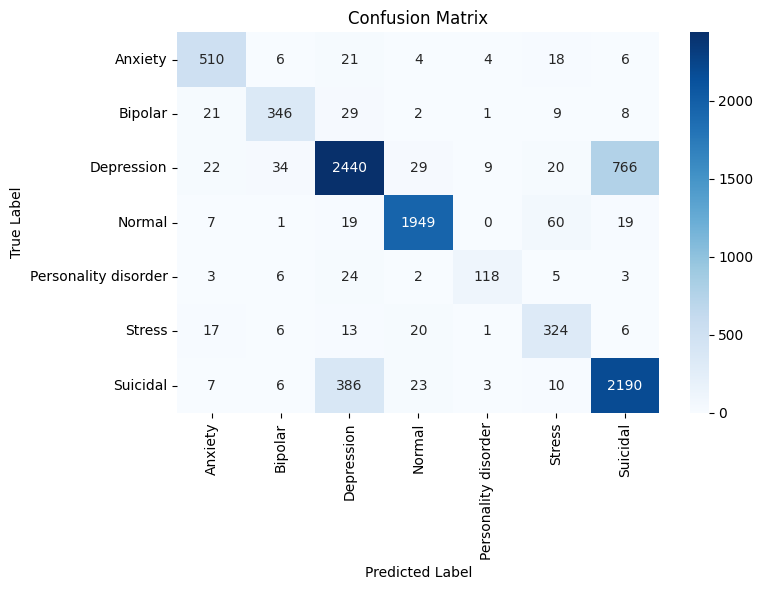


Top 50 Most Confident Wrong Predictions:

1. Confidence: 0.9397
   True: Bipolar | Predicted: Stress
   Text: How I stopped letting anxiety spirals control my life (xpost r/mentallyhealthier) I used to spend most of the day caught up in anxiety spirals. I used to fall into the trap of getting stuck in the pas...
--------------------------------------------------------------------------------

2. Confidence: 0.9393
   True: Suicidal | Predicted: Depression
   Text: Tw// ED I ate something and I needed to purge guys my fucking throat was itching and my head was spinning I knew I had like a 10 minute slot to start but my aunt started fucking telling me that I need...
--------------------------------------------------------------------------------

3. Confidence: 0.9387
   True: Anxiety | Predicted: Bipolar
   Text: I thought I was crazy and alone I’ve suffered from hypercondria for years due to paranoia from almost dying when I was a baby and I thought I was completely crazy. Staying up 

/tmp/ipython-input-23-1241058402.py:134: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(class_confidences, labels=class_names)


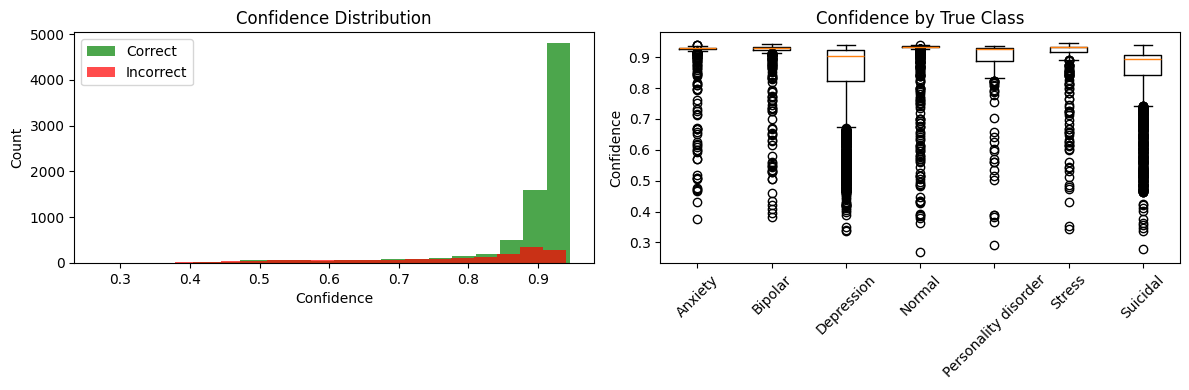

{'accuracy': 0.8262876324347005,
 'predictions': array([6, 2, 6, ..., 4, 5, 2]),
 'labels': array([3, 2, 6, ..., 4, 5, 2]),
 'probabilities': array([[0.01717139, 0.01949799, 0.00946994, ..., 0.02281372, 0.01690792,
         0.76168656],
        [0.01199596, 0.01322705, 0.84694535, ..., 0.01327575, 0.01235224,
         0.08960424],
        [0.01116226, 0.01031385, 0.0496983 , ..., 0.01124624, 0.01048021,
         0.8952724 ],
        ...,
        [0.01197284, 0.01195936, 0.01947   , ..., 0.9219082 , 0.011331  ,
         0.01183235],
        [0.01318507, 0.01114681, 0.01067781, ..., 0.01137117, 0.89077157,
         0.01294441],
        [0.01174419, 0.01132274, 0.90026   , ..., 0.0115988 , 0.01065022,
         0.04247356]], dtype=float32)}

In [24]:
# Perform error analysis
perform_error_analysis(model, test_dataloader, label_encoder, device, test_df[TEXT_COLUMN].tolist())

In [ ]:
# Save model, tokenizer, and label encoder
model_save_path = "last_roberta_model.pt"
label_encoder_save_path = "label_encoder.joblib"
tokenizer_save_path = "roberta_tokenizer"
output_dir = "sentiment_model_components"
os.makedirs(output_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(output_dir, model_save_path))
print(f"Saved model state_dict at: {os.path.join(output_dir, model_save_path)}")
joblib.dump(label_encoder, os.path.join(output_dir, label_encoder_save_path))
print(f"Saved LabelEncoder at: {os.path.join(output_dir, label_encoder_save_path)}")
tokenizer.save_pretrained(os.path.join(output_dir, tokenizer_save_path))
print(f"Saved tokenizer at: {os.path.join(output_dir, tokenizer_save_path)}")
zip_file_name = "sentiment_model_components.zip"
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=output_dir)
            zf.write(file_path, os.path.join(os.path.basename(output_dir), arcname))
print(f"Compressed all components to: {zip_file_name}")

Saved model state_dict at: sentiment_model_components/last_roberta_model.pt
Saved LabelEncoder at: sentiment_model_components/label_encoder.joblib
Saved tokenizer at: sentiment_model_components/roberta_tokenizer
Compressed all components to: sentiment_model_components.zip


In [ ]:
# Model loading
def load_model_and_tokenizer(model_path, tokenizer_path, num_labels, device):
    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path)
    return model, tokenizer

In [ ]:
# Test model loading
print("\nTesting model loading:")
loaded_model, loaded_tokenizer = load_model_and_tokenizer(
    os.path.join(output_dir, model_save_path), os.path.join(output_dir, tokenizer_save_path), NUM_LABELS, device
)
print("Model and tokenizer loaded successfully.")


Testing model loading:
Model and tokenizer loaded successfully.
